In [15]:
import osmnx as ox
import networkx as nx
from shapely.geometry import LineString, Point, Polygon, MultiPolygon
import itertools
import matplotlib.pyplot as plt
import numpy as np
import logging
from sklearn.cluster import DBSCAN
import numpy as np

In [35]:
max_deviation_m = 1000
city_geocode = "Tallinn, Estonia"

/var/folders/hv/7c6y54956n9_w4470fs3q8c00000gn/T/ipykernel_98092/1738126314.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
2025-01-07 22:32:50,401 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


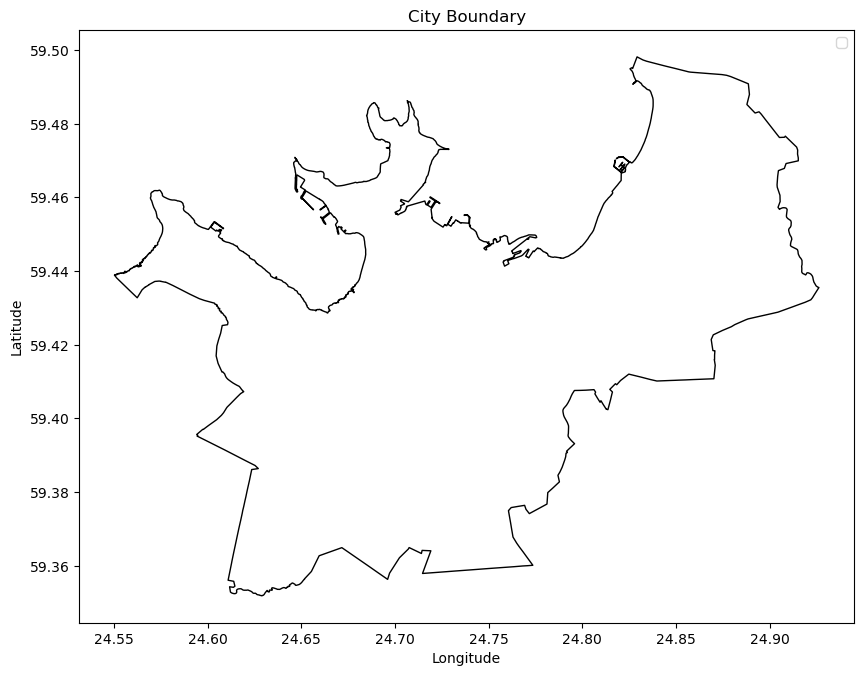

In [ ]:
# Get the GeoDataFrame and extract the boundary
gdf = ox.geocode_to_gdf(city_geocode)

# Check if the geometry is a MultiPolygon
if isinstance(gdf.geometry[0], MultiPolygon):
    # Find the largest polygon by area
    largest_polygon = max(gdf.geometry[0].geoms, key=lambda p: p.area)
    boundary = Polygon(largest_polygon.exterior.coords)
else:
    # Single Polygon case
    boundary = Polygon(list(gdf.geometry[0].exterior.coords))

# Filter the GeoDataFrame to keep only the largest polygon for visualization
filtered_gdf = gdf.copy()
if isinstance(gdf.geometry[0], MultiPolygon):
    filtered_gdf.geometry = [largest_polygon]

# Visual checkpoint: Plot the city boundary
fig, ax = plt.subplots(figsize=(10, 10))
filtered_gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1, label="City Boundary")
plt.title("City Boundary")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

/Users/jakobtjurlik/miniconda3/envs/ox/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jakobtjurlik/miniconda3/envs/ox/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/jakobtjurlik/miniconda3/envs/ox/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/jakobtjurlik/miniconda3/envs/ox/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/jakobtjurlik/miniconda3/envs/ox/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


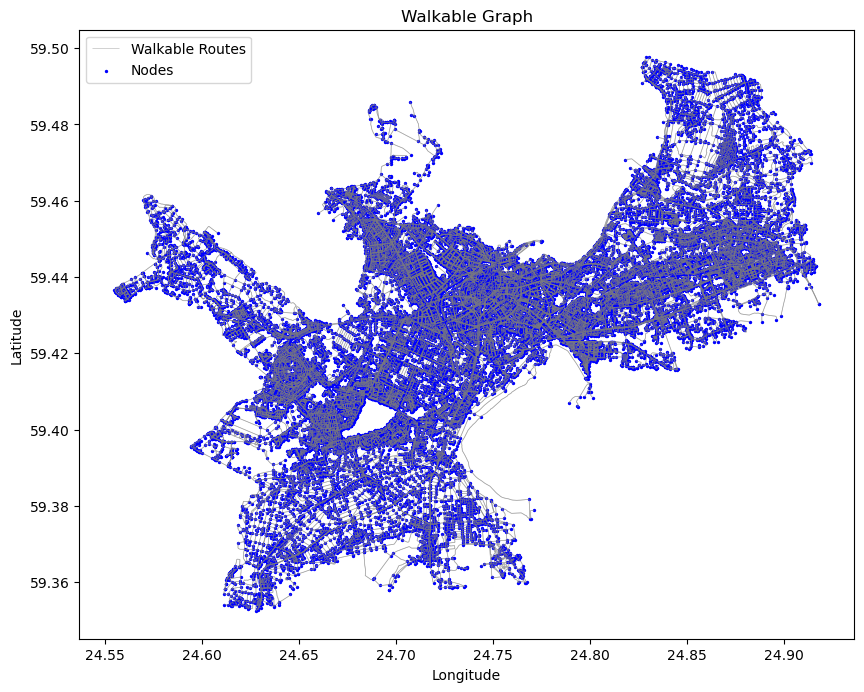

In [29]:
# Build graph of walkable routes within the boundary
graph = ox.graph_from_polygon(boundary, network_type="walk")

# Get nodes and edges from the graph
nodes, edges = ox.graph_to_gdfs(graph)

# Visual checkpoint: Plot the walkable graph
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.5, alpha=0.5, color="gray", label="Walkable Routes")
nodes.plot(ax=ax, color="blue", markersize=2, label="Nodes")
plt.title("Walkable Graph")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

In [30]:
# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger()

In [31]:
# Extract boundary points from the polygon
boundary_points = list(boundary.exterior.coords)

# Convert boundary points to (longitude, latitude) format for clarity
boundary_points = [(lon, lat) for lon, lat in boundary_points]

# Log the number of boundary points
logger.info(f"Extracted {len(boundary_points)} boundary points.")

2025-01-07 22:33:40,206 - INFO - Extracted 8313 boundary points.


In [32]:
# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger()

# Function to calculate distance from a point to a line
def point_to_line_distance(point, line):
    return line.distance(Point(point))

# Function to find the straightest route between two points
def find_straight_route(graph, nodes, start, end, max_deviation):
    straight_line = LineString([start, end])
    valid_nodes = [
        node
        for node in nodes.index
        if point_to_line_distance((nodes.loc[node, "y"], nodes.loc[node, "x"]), straight_line)
        <= max_deviation / 111_000  # Convert meters to degrees
    ]
    if not valid_nodes:
        return None, None, float("inf")
    
    subgraph = graph.subgraph(valid_nodes)
    try:
        start_node = ox.get_nearest_node(subgraph, start)
        end_node = ox.get_nearest_node(subgraph, end)
        shortest_path = nx.shortest_path(subgraph, source=start_node, target=end_node, weight="length")
        path_coords = [(nodes.loc[node, "y"], nodes.loc[node, "x"]) for node in shortest_path]
        deviations = [point_to_line_distance(point, straight_line) for point in path_coords]
        max_actual_deviation = max(deviations) * 111_000  # Convert degrees back to meters
        return path_coords, shortest_path, max_actual_deviation
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        return None, None, float("inf")

In [33]:
# Function to cluster and reduce boundary points using DBSCAN
def cluster_boundary_points(boundary_points, eps=0.001, min_samples=5):
    boundary_array = np.array(boundary_points)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)  # Adjust `eps` for clustering distance
    labels = dbscan.fit_predict(boundary_array)

    cluster_centers = []
    for label in set(labels):
        if label == -1:  # Skip noise points
            continue
        cluster_points = boundary_array[labels == label]
        cluster_centers.append(cluster_points.mean(axis=0))  # Use mean as cluster center

    logger.info(f"Clustering reduced boundary points from {len(boundary_points)} to {len(cluster_centers)}")
    return cluster_centers

In [20]:
# Iterate over all pairs of clustered boundary points to find the optimal route
def find_optimal_route(graph, nodes, boundary_points, max_deviation_m):
    best_route = None
    best_deviation = float("inf")
    best_start = None
    best_end = None
    total_combinations = len(boundary_points) * (len(boundary_points) - 1) // 2

    logger.info(f"Total combinations to evaluate: {total_combinations}")
    progress_interval = max(1, total_combinations // 100)  # Log progress every 1% of total combinations

    for idx, (start, end) in enumerate(itertools.combinations(boundary_points, 2), 1):
        path_coords, path, max_dev = find_straight_route(graph, nodes, start, end, max_deviation_m)
        if path_coords and max_dev < best_deviation:
            best_route = path_coords
            best_deviation = max_dev
            best_start = start
            best_end = end
            logger.info(f"New best route found with maximum deviation {max_dev:.2f} meters")
        
        # Log progress every `progress_interval` combinations
        if idx % progress_interval == 0 or idx == total_combinations:
            logger.info(f"Progress: Evaluated {idx}/{total_combinations} combinations ({(idx / total_combinations) * 100:.2f}%)")

    return best_route, best_start, best_end, best_deviation

In [40]:
# Apply DBSCAN to reduce boundary points
eps = 0.009  # Adjust this value (in degrees) to control clustering density
min_samples = 2  # Minimum number of points per cluster
clustered_boundary_points = cluster_boundary_points(boundary_points, eps=eps, min_samples=min_samples)

# Find the optimal route using the clustered boundary points
best_route, best_start, best_end, best_deviation = find_optimal_route(graph, nodes, clustered_boundary_points, max_deviation_m)

# Output results
if best_route:
    logger.info(f"Optimal starting coordinates: {best_start}")
    logger.info(f"Optimal ending coordinates: {best_end}")
    logger.info(f"Maximum deviation along the route: {best_deviation:.2f} meters")

    # Final visualization: Plot the results
    fig, ax = plt.subplots(figsize=(10, 10))
    nodes.plot(ax=ax, color="lightgray", markersize=1)
    edges.plot(ax=ax, linewidth=0.5, alpha=0.5, color="gray")
    plt.plot([best_start[0], best_end[0]], [best_start[1], best_end[1]], color="red", linestyle="--", label="Straight Line")
    plt.plot(
        [coord[1] for coord in best_route],
        [coord[0] for coord in best_route],
        color="blue",
        label="Optimal Route",
    )
    plt.legend()
    plt.title("Optimal Straight Line Route")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
else:
    logger.warning("No valid route found within the specified maximum deviation.")

2025-01-07 22:35:12,660 - INFO - Clustering reduced boundary points from 8313 to 4
2025-01-07 22:35:12,660 - INFO - Total combinations to evaluate: 6
2025-01-07 22:35:14,492 - INFO - Progress: Evaluated 1/6 combinations (16.67%)
2025-01-07 22:35:16,328 - INFO - Progress: Evaluated 2/6 combinations (33.33%)
2025-01-07 22:35:18,148 - INFO - Progress: Evaluated 3/6 combinations (50.00%)
2025-01-07 22:35:19,952 - INFO - Progress: Evaluated 4/6 combinations (66.67%)
2025-01-07 22:35:21,786 - INFO - Progress: Evaluated 5/6 combinations (83.33%)
2025-01-07 22:35:23,560 - INFO - Progress: Evaluated 6/6 combinations (100.00%)
2025-01-07 22:35:23,561 - WARNING - No valid route found within the specified maximum deviation.
